In [16]:
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Recall, Precision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
import sys
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import os
import cv2 as cv
from sklearn.metrics import roc_auc_score

In [2]:
# Set up the paths to the input directories
train_dir = r"C:\University\6th semester\machine_learning\Face_splittedData\train"
test_dir =  r"C:\University\6th semester\machine_learning\Face_splittedData\test"
# Set up the image dimensions
img_height = 224
img_width = 224

# Set up the HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
channel_axis = -1   

# Define a function to preprocess the images
def preprocess_images(data_dir):
    X = []
    y = []
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.jpg'):
                    img_path = os.path.join(class_dir, file_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_height, img_width))
                    X.append(img)
                    y.append(class_name)
                    
    X = np.array(X)
    y = np.array(y)
    
    # Normalize the data using mean and standard deviation and we applied the normalization before the oversamling to prevent data leakage
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(X.shape[0], -1))
    X = X.reshape(-1, img_height, img_width, 3)
    
    # Apply SMOTE to balance the classes(oversambling as our data is imbalanced)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)
    X_resampled = X_resampled.reshape(-1, img_height, img_width, 3)
    
   
    
    
    # Perform label encoding on the target variable (labels)
    label_encoder = LabelEncoder()
    y_resampled = label_encoder.fit_transform(y_resampled)
    
    return X_resampled, y_resampled




In [3]:
# Preprocess the training data
train_X, train_y = preprocess_images(train_dir)

# Preprocess the testing data
test_X, test_y = preprocess_images(test_dir)

In [14]:
train_X.shape

(1346, 224, 224, 3)

In [17]:
# model architecture

with tf.device('/device:GPU:0'):


    model = models.Sequential()

    model.add(layers.Conv2D(32, (7, 7),strides=4, activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2),strides=2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2),strides=2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),strides=2))



    model.add(layers.GlobalMaxPooling2D())


    model.add(layers.Dense(1080, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))


    model.summary()    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 32)        4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                        

In [18]:
metrics = ['accuracy',
               tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall')]

In [20]:
# run of the model 

with tf.device('/device:CPU:0'):
#     class_weights = {}
#     class_totals = np.sum(to_categorical(y_train), axis=0)
#     total_samples = np.sum(class_totals)
#     class_weights
#     for i in range(len(class_totals)):
#         class_weight = total_samples / (len(class_totals) * class_totals[i])
#         class_weights[i] = class_weight
#     print(class_weights)
#     arr=np.array(y_train)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=metrics)

    history = model.fit(train_X, train_y,batch_size=64 ,epochs=10,shuffle=True,
                        validation_data=(test_X, test_y))

Epoch 1/10
22/22 [==============================] - 4s 155ms/step - loss: 0.5508 - accuracy: 0.6917 - precision: 0.7067 - recall: 0.6553 - val_loss: 0.7092 - val_accuracy: 0.5217 - val_precision: 0.5111 - val_recall: 1.0000
Epoch 2/10
22/22 [==============================] - 3s 133ms/step - loss: 0.2164 - accuracy: 0.8975 - precision: 0.8860 - recall: 0.9123 - val_loss: 0.4286 - val_accuracy: 0.9012 - val_precision: 0.8350 - val_recall: 1.0000
Epoch 3/10
22/22 [==============================] - 3s 126ms/step - loss: 0.0489 - accuracy: 0.9874 - precision: 0.9866 - recall: 0.9881 - val_loss: 0.2074 - val_accuracy: 0.9704 - val_precision: 0.9837 - val_recall: 0.9565
Epoch 4/10
22/22 [==============================] - 3s 123ms/step - loss: 0.0402 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - val_loss: 0.1249 - val_accuracy: 0.9723 - val_precision: 0.9959 - val_recall: 0.9486
Epoch 5/10
22/22 [==============================] - 3s 125ms/step - loss: 0.0477 - accuracy: 0.9859 - pr

In [22]:
with tf.device('/device:CPU:0'):
    y_pred = model.predict(test_X)

16/16 [==============================] - 0s 19ms/step


In [24]:
# Convert the predicted probabilities to class labels
threshold = 0.5

y_pred_classes = np.where(y_pred >= threshold, 1, 0)

conf_mat = confusion_matrix(test_y, y_pred_classes)

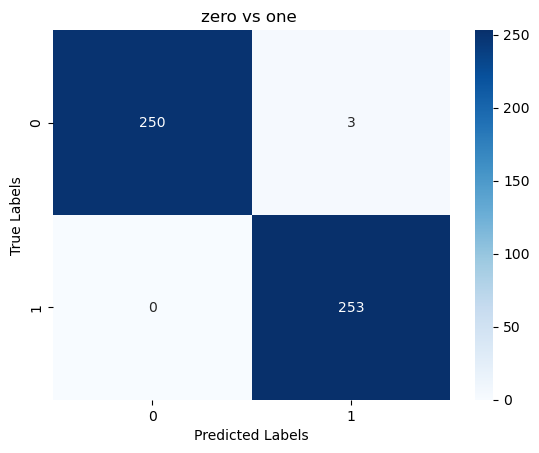

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(test_y, y_pred_classes)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues",fmt='g')

# Add labels and title to the plot
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("zero vs one ")

# Show the plot
plt.show()

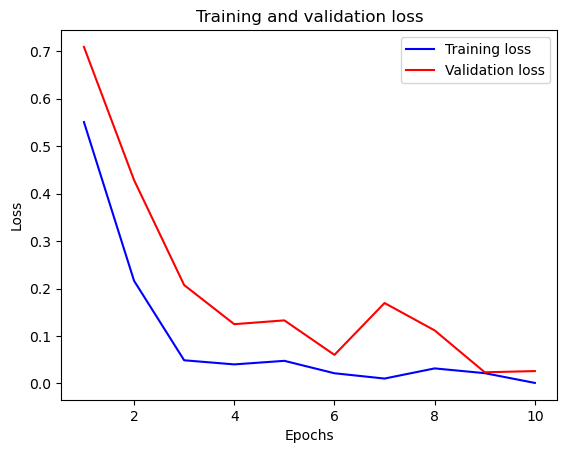

In [28]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

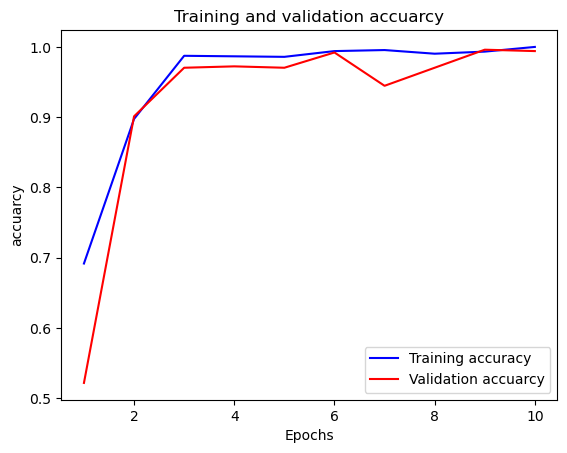

In [29]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation accuarcy')
plt.title('Training and validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('accuarcy')
plt.legend()

plt.show()

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

# assume y_true and y_pred are the ground truth and predicted labels respectively
# for a multi-class classification problem with classes 0 to n-1
cm = confusion_matrix(test_y, y_pred_classes)
report = classification_report(test_y, y_pred_classes)

# recall for each class can be obtained from the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       253
           1       0.99      1.00      0.99       253

    accuracy                           0.99       506
   macro avg       0.99      0.99      0.99       506
weighted avg       0.99      0.99      0.99       506



In [33]:
# calculate AUC score
auc_score = roc_auc_score(test_y, y_pred_classes)

# print the AUC score
print("AUC score: {:.2f}".format(auc_score))

AUC score: 0.99
